<center>
<h1> Credit Risk Analytics
</center>

###### Definition of Target and Outcome Window:
One of the leading banks would like to predict bad customer while customer applying for loan. This model also called as PD Models (Probability of Default)


###### Data Pre-Processing - 
    - Missing Values Treatment - Numerical (Mean/Median imputation) and Categorical (Separate Missing Category or Merging)
    - Univariate Analysis - Outlier and Frequency Analysis
###### Data Exploratory Analysis
    - Bivariate Analysis - Numeric(TTest) and Categorical(Chisquare)
    - Bivariate Analysis - Visualization
    - Variable Transformation - P-Value based selection
    - Variable Transformation - Bucketing / Binning for numerical variables and Dummy for Categorical Variables
    - Variable Reduction - IV / Somers'D
    - Variable Reduction - Multicollinearity
###### Model Build and Model Diagnostics
    - Train and Test split
    - Significance of each Variable
    - Gini and ROC / Concordance analysis - Rank Ordering
    - Classification Table Analysis - Accuracy

###### Model Validation
    - OOS validation - p-value and sign testing for the model coefficients
    - Diagnostics check to remain similar to Training Model build
    - BootStrapping, if necessary
###### Model Interpretation for its properties
    - Inferencing for finding the most important contributors
    - Prediction of risk and proactive prevention by targeting segments of the population

#### import the packages

In [18]:
# import the packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = 10, 7.5
plt.rcParams['axes.grid'] = True

! pip install pandas_profiling == 1.3
import pandas_profiling   #need to install using anaconda prompt (pip install pandas_profiling)
import scipy.stats as stats
import statsmodels.formula.api as sm

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from statsmodels.stats.outliers_influence import variance_inflation_factor
from patsy import dmatrices

ERROR: Invalid requirement: '=='


ModuleNotFoundError: No module named 'pandas_profiling'

#### data import

In [6]:
# import the data under consideration
bankloans = pd.read_csv('bankloans.csv')
bankloans.head()

,age,ed,employ,address,income,debtinc,creddebt,othdebt,default
0,41,3,17,12,176,9.3,11.359392,5.008608,1.0
1,27,1,10,6,31,17.3,1.362202,4.000798,0.0
2,40,1,15,14,55,5.5,0.856075,2.168925,0.0
3,41,1,15,14,120,2.9,2.658720,0.821280,0.0
4,24,2,2,0,28,17.3,1.787436,3.056564,1.0


#### UDFs

In [7]:
# Create Data audit Report for continuous variables
def continuous_var_summary(x):
    return pd.Series([x.count(), x.isnull().sum(), x.sum(), x.mean(), x.median(),  
                      x.std(), x.var(), x.min(), x.quantile(0.01), x.quantile(0.05),
                          x.quantile(0.10),x.quantile(0.25),x.quantile(0.50),x.quantile(0.75), 
                              x.quantile(0.90),x.quantile(0.95), x.quantile(0.99),x.max()], 
                  index = ['N', 'NMISS', 'SUM', 'MEAN','MEDIAN', 'STD', 'VAR', 'MIN', 'P1', 
                               'P5' ,'P10' ,'P25' ,'P50' ,'P75' ,'P90' ,'P95' ,'P99' ,'MAX'])

In [8]:
# Create Data audit Report for categorical variables
def categorical_var_summary(x):
    Mode = x.value_counts().sort_values(ascending = False)[0:1].reset_index()
    return pd.Series([x.count(), x.isnull().sum(), Mode.iloc[0, 0], Mode.iloc[0, 1], 
                          round(Mode.iloc[0, 1] * 100/x.count(), 2)], 
                  index = ['N', 'NMISS', 'MODE', 'FREQ', 'PERCENT'])

In [9]:
# Missing value imputation for categorical and continuous variables
def missing_imputation(x, stats = 'mean'):
    if (x.dtypes == 'float64') | (x.dtypes == 'int64'):
        x = x.fillna(x.mean()) if stats == 'mean' else x.fillna(x.median())
    else:
        x = x.fillna(x.mode())
    return x

#### data inspection

In [15]:
# check the metadata
bankloans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 850 entries, 0 to 849
Data columns (total 9 columns):
age         850 non-null int64
ed          850 non-null int64
employ      850 non-null int64
address     850 non-null int64
income      850 non-null int64
debtinc     850 non-null float64
creddebt    850 non-null float64
othdebt     850 non-null float64
default     700 non-null float64
dtypes: float64(4), int64(5)
memory usage: 59.8 KB


In [10]:
# profiling using pandas_profiling
# screen the variables and make a note of potential variables for model refinement
profile_report = pandas_profiling.ProfileReport(bankloans)
profile_report.to_file(output_file = 'profilereport.html')

NameError: name 'pandas_profiling' is not defined

In [21]:
# separate the categorical and continuous variable names
numeric_var_names = [key for key in dict(bankloans.dtypes) 
                     if dict(bankloans.dtypes)[key] in ['float64', 'int64', 'float32', 'int32']]
cat_var_names = [key for key in dict(bankloans.dtypes) if dict(bankloans.dtypes)[key] in ['object']]

In [23]:
# print the variable names in both the variables
print(numeric_var_names)
print(cat_var_names)

[]


In [24]:
# get the dataframe of only continuous variables
bankloans_num = bankloans[numeric_var_names]

In [25]:
# get the data audit report for all the variables
num_summary = bankloans_num.apply(continuous_var_summary).T
num_summary

,N,NMISS,SUM,MEAN,MEDIAN,STD,VAR,MIN,P1,P5,P10,P25,P50,P75,P90,P95,P99,MAX
age,850.0,0.0,29775.000000,35.029412,34.000000,8.041432,64.664623,20.000000,21.000000,23.000000,25.000000,29.000000,34.000000,41.000000,47.000000,49.000000,53.000000,56.00000
ed,850.0,0.0,1454.000000,1.710588,1.000000,0.927784,0.860783,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000,3.000000,4.000000,4.000000,5.00000
employ,850.0,0.0,7281.000000,8.565882,7.000000,6.777884,45.939706,0.000000,0.000000,0.000000,1.000000,3.000000,7.000000,13.000000,18.000000,21.550000,29.000000,33.00000
address,850.0,0.0,7116.000000,8.371765,7.000000,6.895016,47.541251,0.000000,0.000000,0.000000,1.000000,3.000000,7.000000,12.000000,19.000000,22.550000,26.510000,34.00000
income,850.0,0.0,39674.000000,46.675294,35.000000,38.543054,1485.566998,13.000000,14.490000,17.000000,19.000000,24.000000,35.000000,55.750000,84.000000,115.550000,220.510000,446.00000
debtinc,850.0,0.0,8645.900000,10.171647,8.700000,6.719441,45.150891,0.100000,0.900000,1.900000,2.900000,5.100000,8.700000,13.800000,19.200000,23.510000,31.565000,41.30000
creddebt,850.0,0.0,1340.284021,1.576805,0.885091,2.125840,4.519196,0.011696,0.030349,0.108927,0.178306,0.382176,0.885091,1.898440,3.703304,5.348674,10.285997,20.56131
othdebt,850.0,0.0,2616.970979,3.078789,2.003243,3.398803,11.551864,0.045584,0.162394,0.359900,0.552050,1.045942,2.003243,3.903001,7.111941,9.481105,16.931503,35.19750
default,700.0,150.0,183.000000,0.261429,0.000000,0.439727,0.193360,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.00000


#### seperate out the data for existing and the new customers

In [26]:
bankloans_existing = bankloans_num[bankloans_num.default.isnull() == 0]
bankloans_new = bankloans_num[bankloans_num.default.isnull() == 1]
print(bankloans_existing.shape)
print(bankloans_new.shape)

(700, 9)
(150, 9)


#### data prepration/data cleaning

In [27]:
# Handling Outliers
bankloans_existing = bankloans_existing.apply(lambda x: x.clip(lower = x.dropna().quantile(0.01), upper = x.dropna().quantile(0.99)))

In [28]:
# Handling missings
bankloans_existing = bankloans_existing.apply(lambda x: missing_imputation(x))

#### bi variate analysis to identify corr 

In [29]:
# correlation matrix
corr_matrix = bankloans_existing.corr()
corr_matrix.to_csv('corr.csv')

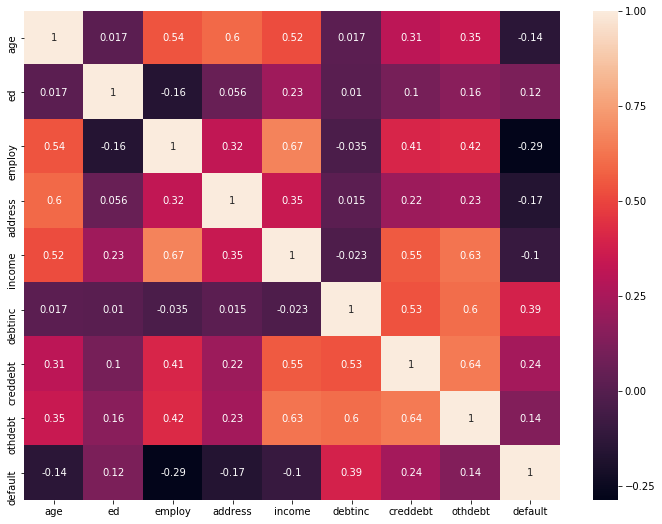

In [30]:
# visualize correlation matrix in Seaborn using a heatmap
plt.figure(figsize = (12, 9))
sns.heatmap(bankloans_existing.corr(), annot=True)

### Building logistic Regression Model

In [31]:
# import the package for logistic regression
import statsmodels.formula.api as sm

In [32]:
# Train and Test split
train, test = train_test_split(bankloans_existing, test_size = 0.3, random_state =  42)

In [33]:
# print the columns
train.columns

Index(['age', 'ed', 'employ', 'address', 'income', 'debtinc', 'creddebt',
       'othdebt', 'default'],
      dtype='object')

In [34]:
#'default ~ age + ed + employ + address + income + debtinc + creddebt + othdebt'

In [35]:
# execute a model for the X variables
m1 = sm.logit(formula = 'default ~ age + employ + address + debtinc + creddebt', 
                  data = train).fit() 

Optimization terminated successfully.
         Current function value: 0.427051
         Iterations 7


In [36]:
# print the model summary stats 
print(m1.summary2())

                         Results: Logit
Model:              Logit            Pseudo R-squared: 0.272     
Dependent Variable: default          AIC:              430.5102  
Date:               2020-05-01 11:55 BIC:              455.6766  
No. Observations:   490              Log-Likelihood:   -209.26   
Df Model:           5                LL-Null:          -287.47   
Df Residuals:       484              LLR p-value:      5.6901e-32
Converged:          1.0000           Scale:            1.0000    
No. Iterations:     7.0000                                       
------------------------------------------------------------------
               Coef.   Std.Err.     z     P>|z|    [0.025   0.975]
------------------------------------------------------------------
Intercept     -1.7615    0.5836  -3.0185  0.0025  -2.9053  -0.6177
age            0.0392    0.0201   1.9528  0.0508  -0.0001   0.0785
employ        -0.2541    0.0348  -7.3056  0.0000  -0.3223  -0.1860
address       -0.0839    0.025

In [37]:
m1.predict(train)

357    0.585803
649    0.529728
291    0.060701
420    0.599717
177    0.130221
456    0.047856
444    0.637876
83     0.296777
453    0.573234
354    0.454658
536    0.047128
576    0.107590
79     0.012572
23     0.097529
15     0.114948
381    0.727715
292    0.002871
275    0.499827
654    0.407165
314    0.530538
610    0.474986
137    0.064829
486    0.216394
571    0.272272
33     0.179819
588    0.112427
257    0.379924
9      0.835134
22     0.276549
544    0.011249
         ...   
252    0.049232
21     0.005207
313    0.277269
459    0.058321
160    0.384225
276    0.538994
191    0.429667
385    0.687257
413    0.629780
491    0.202360
343    0.986816
308    0.110964
661    0.219561
130    0.232946
663    0.055607
99     0.417265
372    0.083720
87     0.396660
458    0.471869
330    0.295769
214    0.162736
466    0.733566
121    0.297523
614    0.076481
20     0.005726
71     0.702234
106    0.185621
270    0.013897
435    0.416715
102    0.098704
Length: 490, dtype: floa

#### Data Exploratory Analysis
    - Variable Reduction using Somer's D values
    - Bi-variate analysis technique to check the predictive power of each independent against dependent
    - cutoff is 0.2 or 20% below which the variable is insignificant

In [38]:
# list all the columns 
print(bankloans_existing.columns)

Index(['age', 'ed', 'employ', 'address', 'income', 'debtinc', 'creddebt',
       'othdebt', 'default'],
      dtype='object')


In [40]:
# example to get the Somer's D for one variable
logreg_model = sm.logit('default ~ debtinc', data= bankloans_existing).fit()

Optimization terminated successfully.
         Current function value: 0.501389
         Iterations 6


In [41]:
# predict the probabilities
p = logreg_model.predict(bankloans_existing)

In [42]:
p

0      0.212978
1      0.439629
2      0.140317
3      0.103531
4      0.439629
5      0.233738
6      0.821553
7      0.112500
8      0.668629
9      0.519154
10     0.089623
11     0.135571
12     0.229006
13     0.407161
14     0.208552
15     0.197784
16     0.410376
17     0.177518
18     0.143558
19     0.089623
20     0.107295
21     0.141930
22     0.229006
23     0.224342
24     0.462687
25     0.449485
26     0.160704
27     0.420068
28     0.475941
29     0.341836
         ...   
670    0.153655
671    0.301242
672    0.084341
673    0.255864
674    0.113835
675    0.155393
676    0.273996
677    0.094061
678    0.212978
679    0.104773
680    0.697420
681    0.222035
682    0.266128
683    0.153655
684    0.240963
685    0.400754
686    0.183421
687    0.236130
688    0.248339
689    0.245863
690    0.171765
691    0.169881
692    0.785956
693    0.127962
694    0.282007
695    0.126485
696    0.266128
697    0.177518
698    0.193596
699    0.356957
Length: 700, dtype: floa

In [43]:
# get the AUC (Concordance)
metrics.roc_auc_score(bankloans_existing['default'], p)

0.7352527718764202

In [44]:
# get the meaning of this statement
2 * metrics.roc_auc_score(bankloans_existing['default'], p) - 1

0.4705055437528405

#### get the Somer's D values for all the X variables

In [45]:
# empty dataframe
somersd_df = pd.DataFrame()

# iterate for each of the X - dependant variables and get the Somer's D value
for num_variable in bankloans_existing.columns.difference(['default']):
    
    # execute teh logit model
    logreg = sm.logit(formula = str('default ~ ') + str(num_variable), data = bankloans_existing).fit()
    
    # get the predicted probabilities and create a dataframe with the predicted values
    y_score = pd.DataFrame(logreg.predict())
    
    # name the column of the df as score
    y_score.columns = ['Score']
    
    # calculate the Somer's D values
    somers_d = 2 * metrics.roc_auc_score(bankloans_existing['default'], y_score) - 1
    
    # place the variable name and the Somers' D score in a temp dataframe
    temp = pd.DataFrame([num_variable, somers_d]).T
    temp.columns = ['Variable Name', 'SomersD']
    
    # append the data in the dataframe for all the X variables
    somersd_df = pd.concat([somersd_df, temp], axis=0)

Optimization terminated successfully.
         Current function value: 0.559856
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.564673
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.548956
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.501389
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.567774
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.527166
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.569055
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.565619
         Iterations 5


In [47]:
# print the Somer's D values for all variables
# Bi-variate analysis to check the predictive power of each independent against dependent
somersd_df.sort_values(by = 'SomersD', ascending = False)

,Variable Name,SomersD
0,debtinc,0.470506
0,employ,0.409138
0,creddebt,0.272378
0,address,0.222384
0,age,0.206329
0,income,0.200273
0,othdebt,0.173806
0,ed,0.148302


#### VIF - Variance Inflation Factor

In [48]:
# get all the dependent avriables
features = ' + '.join(bankloans_existing.columns.difference(['default']))
features

'address + age + creddebt + debtinc + ed + employ + income + othdebt'

In [49]:
# run the dmatrices
a, b = dmatrices('default ~ ' + features, data = bankloans_existing, return_type = 'dataframe')

# get the VIF
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(b.values, i) for i in range(b.shape[1])]
vif["features"] = b.columns

vif

,VIF Factor,features
0,36.910987,Intercept
1,1.561802,address
2,2.037593,age
3,2.628899,creddebt
4,3.910509,debtinc
5,1.287345,ed
6,2.401544,employ
7,5.121585,income
8,4.562072,othdebt


### predict the values

In [50]:
# predict the values on training and testing
train['pred_prob'] = m1.predict(train)
train_predict = m1.predict(train)
test_predict = m1.predict(test)
train.head(20)

/Users/kartikmahajan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,age,ed,employ,address,income,debtinc,creddebt,othdebt,default,pred_prob
357,24.0,2,0.0,2.0,15.0,16.100,0.321195,2.093805,1.0,0.585803
649,29.0,2,5.0,7.0,28.0,18.700,2.125816,3.110184,0.0,0.529728
291,33.0,4,9.0,8.0,32.0,5.500,0.496320,1.263680,0.0,0.060701
420,46.0,1,1.0,15.0,21.0,14.800,1.376844,1.731156,1.0,0.599717
177,28.0,2,7.0,2.0,34.0,7.000,0.359380,2.020620,0.0,0.130221
456,37.0,4,9.0,16.0,177.0,5.900,0.887655,9.555345,0.0,0.047856
444,43.0,4,18.0,14.0,190.3,6.500,9.891428,12.958530,1.0,0.637876
83,35.0,4,4.0,16.0,29.0,11.000,1.843820,1.346180,0.0,0.296777
453,39.0,1,0.0,8.0,39.0,7.900,1.066026,2.014974,0.0,0.573234
354,41.0,3,18.0,6.0,71.0,15.700,6.565583,4.581417,1.0,0.454658


- p (Default = 1) = exp(LE) / (1 + exp(LE)) 

#### check model accuracy

In [51]:
metrics.accuracy_score( train['default'],
                            train_predict>0.27)

0.7387755102040816

In [52]:
# model performance | Method 1: AUC
train_auc = metrics.roc_auc_score(train['default'], train_predict)
test_auc = metrics.roc_auc_score(test['default'], test_predict)

print("The AUC for the model built on the Train Data is : ", train_auc)
print("The AUC for the model built on the Test Data is : ", test_auc)

The AUC for the model built on the Train Data is :  0.838210632232098
The AUC for the model built on the Test Data is :  0.8885790340981113


In [53]:
print("Response rate (Proportion of 1 vs 0):", train['default'].mean())
print("Average of predicted probalities:", train_predict.mean())

Response rate (Proportion of 1 vs 0): 0.27346938775510204
Average of predicted probalities: 0.27346938775510227


#### combine the actual Y values with predicted probabilities

In [54]:
## Intuition behind ROC curve - predicted probability as a tool for separating the '1's and '0's
train_predicted_prob = pd.DataFrame(train_predict)
train_predicted_prob.columns = ['prob']

# making a DataFrame with actual and prob columns
train_pf = pd.concat([train['default'], train_predicted_prob], axis = 1)
train_pf.columns = ['actual', 'prob']

In [55]:
## Intuition behind ROC curve - predicted probability as a tool for separating the '1's and '0's
test_predicted_prob = pd.DataFrame(test_predict)
test_predicted_prob.columns = ['prob']

# making a DataFrame with actual and prob columns
test_pf = pd.concat([test['default'], test_predicted_prob], axis=1)
test_pf.columns = ['actual','prob']

test_pf.head()

,actual,prob
158,1.0,0.213639
500,0.0,0.462511
396,0.0,0.058998
155,0.0,0.296444
321,1.0,0.300336


In [56]:
# Creating a confusion matrix

from sklearn import metrics

cm = metrics.confusion_matrix( train['default'],
                            train_predict>0.2,[1,0])
cm

array([[119,  15],
       [131, 225]])

In [72]:
from sklearn import metrics

cm1 = metrics.confusion_matrix( train['default'],
                            train_predict>0.23,[1,0])
cm1

array([[114,  20],
       [118, 238]])

In [59]:
train['default'].value_counts()

0.0    356
1.0    134
Name: default, dtype: int64

In [60]:
import matplotlib.pyplot as plt
import seaborn as sn
%matplotlib inline

Text(0.5, 15.0, 'Predicted label')

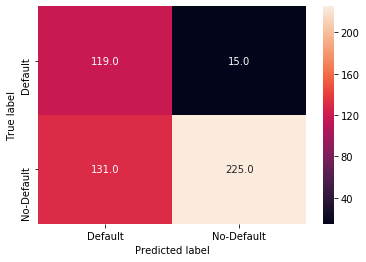

In [62]:
sn.heatmap(cm, annot=True,  fmt='.1f', xticklabels = ["Default", "No-Default"] , yticklabels = ["Default", "No-Default"] )
plt.ylabel('True label')
plt.xlabel('Predicted label')

Text(0.5, 15.0, 'Predicted label')

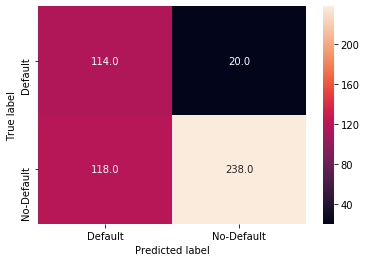

In [73]:
sn.heatmap(cm1, annot=True,  fmt='.1f', xticklabels = ["Default", "No-Default"] , yticklabels = ["Default", "No-Default"] )
plt.ylabel('True label')
plt.xlabel('Predicted label')

#### calculate the confusion matrix parameters

In [64]:
## Intuition behind ROC curve - confusion matrix for each different cut-off shows trade off in sensitivity and specificity
roc_like_df = pd.DataFrame()
train_temp = train_pf.copy()

for cut_off in np.linspace(0,1,1000):
    
    train_temp['cut_off'] = cut_off
    train_temp['predicted'] = train_temp['prob'].apply(lambda x: 0.0 if x < cut_off else 1.0)
    train_temp['tp'] = train_temp.apply(lambda x: 1.0 if x['actual']==1.0 and x['predicted']==1 else 0.0, axis=1)
    train_temp['fp'] = train_temp.apply(lambda x: 1.0 if x['actual']==0.0 and x['predicted']==1 else 0.0, axis=1)
    train_temp['tn'] = train_temp.apply(lambda x: 1.0 if x['actual']==0.0 and x['predicted']==0 else 0.0, axis=1)
    train_temp['fn'] = train_temp.apply(lambda x: 1.0 if x['actual']==1.0 and x['predicted']==0 else 0.0, axis=1)
    sensitivity = train_temp['tp'].sum() / (train_temp['tp'].sum() + train_temp['fn'].sum())
    specificity = train_temp['tn'].sum() / (train_temp['tn'].sum() + train_temp['fp'].sum())
    accuracy = (train_temp['tp'].sum()  + train_temp['tn'].sum() ) / (train_temp['tp'].sum() + train_temp['fn'].sum() + train_temp['tn'].sum() + train_temp['fp'].sum())
    roc_like_table = pd.DataFrame([cut_off, sensitivity, specificity, accuracy]).T
    roc_like_table.columns = ['cutoff', 'sensitivity', 'specificity', 'accuracy']
    roc_like_df = pd.concat([roc_like_df, roc_like_table], axis=0)

roc_like_df['senstivity+specificity'] = roc_like_df['sensitivity'] + roc_like_df['specificity']
roc_like_df

,cutoff,sensitivity,specificity,accuracy,senstivity+specificity
0,0.000000,1.000000,0.000000,0.273469,1.000000
0,0.001001,1.000000,0.000000,0.273469,1.000000
0,0.002002,1.000000,0.014045,0.283673,1.014045
0,0.003003,1.000000,0.028090,0.293878,1.028090
0,0.004004,1.000000,0.042135,0.304082,1.042135
0,0.005005,1.000000,0.053371,0.312245,1.053371
0,0.006006,1.000000,0.070225,0.324490,1.070225
0,0.007007,1.000000,0.081461,0.332653,1.081461
0,0.008008,1.000000,0.089888,0.338776,1.089888
0,0.009009,1.000000,0.095506,0.342857,1.095506


#### finding ideal cut-off
    - Choosen Best Cut-off is 0.23 based on highest (sensitivity+specicity)

In [66]:
# cut-off based on highest sum(sensitivity + specicity) - common way of identifying cut-off
roc_like_df[roc_like_df['senstivity+specificity'] == roc_like_df['senstivity+specificity'].max()]

,cutoff,sensitivity,specificity,accuracy,senstivity+specificity
0,0.216216,0.880597,0.654494,0.716327,1.535091


In [67]:
# cut-off based on highest accuracy - can be misleading in case imbalanced data
roc_like_df[roc_like_df['accuracy'] == roc_like_df['accuracy'].max()]

,cutoff,sensitivity,specificity,accuracy,senstivity+specificity
0,0.533534,0.410448,0.949438,0.802041,1.359886
0,0.534535,0.410448,0.949438,0.802041,1.359886
0,0.535536,0.410448,0.949438,0.802041,1.359886
0,0.536537,0.410448,0.949438,0.802041,1.359886
0,0.537538,0.410448,0.949438,0.802041,1.359886
0,0.538539,0.410448,0.949438,0.802041,1.359886


#### do the final predictions at the 0.23 as cutoff

In [68]:
test_pf['predicted'] = test_pf['prob'].apply(lambda x: 1 if x > 0.22 else 0)
train_pf['predicted'] = train_pf['prob'].apply(lambda x: 1 if x > 0.22 else 0)

In [69]:
# confusion matrix of training dataset
pd.crosstab(train_pf['actual'], train_pf['predicted'])

predicted,0,1
actual,,
0.0,235,121
1.0,18,116


In [70]:
# confusion matrix of testing dataset
pd.crosstab(test_pf['actual'], test_pf['predicted'])

predicted,0,1
actual,,
0.0,116,45
1.0,6,43


In [74]:
print("The overall accuracy score for the Train Data is : ", metrics.accuracy_score(train_pf.actual, train_pf.predicted))
print("The overall accuracy score for the Test Data  is : ", metrics.accuracy_score(test_pf.actual, test_pf.predicted))

The overall accuracy score for the Train Data is :  0.7163265306122449
The overall accuracy score for the Test Data  is :  0.7571428571428571


## Predicting new customers (Implementation of Model on new data)

In [75]:
# predciting new customers good or bad
bankloans_new.head()

,age,ed,employ,address,income,debtinc,creddebt,othdebt,default
700,36,1,16,13,32,10.9,0.544128,2.943872,NaN
701,50,1,6,27,21,12.9,1.316574,1.392426,NaN
702,40,1,9,9,33,17.0,4.880700,0.729300,NaN
703,31,1,5,7,23,2.0,0.046000,0.414000,NaN
704,29,1,4,0,24,7.8,0.866736,1.005264,NaN


#### before scoring new customers, you need to process the data using the sames steps you followed while building the model

In [76]:
bankloans_new['prob'] = m1.predict(bankloans_new)
bankloans_new.head()

/Users/kartikmahajan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,age,ed,employ,address,income,debtinc,creddebt,othdebt,default,prob
700,36,1,16,13,32,10.9,0.544128,2.943872,NaN,0.012035
701,50,1,6,27,21,12.9,1.316574,1.392426,NaN,0.131542
702,40,1,9,9,33,17.0,4.880700,0.729300,NaN,0.710254
703,31,1,5,7,23,2.0,0.046000,0.414000,NaN,0.096595
704,29,1,4,0,24,7.8,0.866736,1.005264,NaN,0.361547


In [79]:
bankloans_new['default'] = bankloans_new['prob'].apply(lambda x: 1 if x > 0.22 else 0)

/Users/kartikmahajan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [80]:
bankloans_new.default.value_counts()

0    83
1    67
Name: default, dtype: int64

#### We are rejecting applications for 64 customers based on cut-off = 0.24

### Decile Analysis

In [81]:
#Decile analysis
#Top-two deciles - High risk customers - will reject applications
#3rd,4th, 5th deciesl - medium risk customers - will accept application with proper scrutiny
#6th decile onwards - low risk customers - accept the application

In [82]:
#Decile analysis for validation of models - Business validation
train_pf['Deciles'] = pd.qcut(train_pf['prob'], 10, labels = False)

test_pf['Deciles'] = pd.qcut(test_pf['prob'], 10, labels = False)

#### Decile Analysis for train data

In [83]:
no_1s = train_pf[['Deciles','actual']].groupby(train_pf.Deciles).sum().sort_index(ascending=False)['actual']

no_total = train_pf[['Deciles','actual']].groupby(train_pf.Deciles).count().sort_index(ascending=False)['actual']

max_prob = train_pf[['Deciles','prob']].groupby(train_pf.Deciles).max().sort_index(ascending=False)['prob']

min_prob = train_pf[['Deciles','prob']].groupby(train_pf.Deciles).min().sort_index(ascending=False)['prob']

In [88]:
Decile_analysis_train = pd.concat([ min_prob, max_prob, no_1s, no_total-no_1s, no_total], axis=1)

In [89]:
Decile_analysis_train.columns = ['Min_prob', 'Max_prob', '#1', '#0', 'Total']

In [90]:
Decile_analysis_train.to_csv('Decile_analysis_train.csv')
Decile_analysis_train

,Min_prob,Max_prob,#1,#0,Total
Deciles,,,,,
9,0.629780,0.986816,37.0,12.0,49
8,0.492289,0.625658,29.0,20.0,49
7,0.396660,0.491821,18.0,31.0,49
6,0.289372,0.396070,19.0,30.0,49
5,0.215034,0.288422,15.0,34.0,49
4,0.144435,0.211515,6.0,43.0,49
3,0.084038,0.143758,5.0,44.0,49
2,0.040619,0.083720,3.0,46.0,49
1,0.013535,0.040588,2.0,47.0,49


#### Decile Analysis for test data

In [91]:
no_1s = test_pf[['Deciles','actual']].groupby(test_pf.Deciles).sum().sort_index(ascending=False)['actual']
no_total = test_pf[['Deciles','actual']].groupby(test_pf.Deciles).count().sort_index(ascending=False)['actual']
max_prob = test_pf[['Deciles','prob']].groupby(test_pf.Deciles).max().sort_index(ascending=False)['prob']
min_prob = test_pf[['Deciles','prob']].groupby(test_pf.Deciles).min().sort_index(ascending=False)['prob']

In [92]:
Decile_analysis_test = pd.concat([min_prob, max_prob, no_1s, no_total-no_1s, no_total], axis=1)

In [93]:
Decile_analysis_test.columns = ['Min_prob', 'Max_prob', '#1', '#0', 'Total']

In [94]:
Decile_analysis_test.to_csv('Decile_analysis_test.csv')
Decile_analysis_test

,Min_prob,Max_prob,#1,#0,Total
Deciles,,,,,
9,0.677376,0.972221,19.0,2.0,21
8,0.491667,0.674228,12.0,9.0,21
7,0.320771,0.481541,5.0,16.0,21
6,0.254996,0.312851,5.0,16.0,21
5,0.168005,0.241181,4.0,17.0,21
4,0.117243,0.166776,1.0,20.0,21
3,0.066399,0.116729,2.0,19.0,21
2,0.040592,0.065938,1.0,20.0,21
1,0.017485,0.037297,0.0,21.0,21
